In [2]:
## load required libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import numpy as np
from os import mkdir
from zipfile import ZipFile
from tensorflow.keras.models import load_model

import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import glob
import shutil

## Deep Convolutional Generative Adversarial Networks - DCGAN
## - for Dog Images
Generative Adversarial Netwroks (GAN) are a type of machine learning method used to create new data with characteristics similar to some training dataset. They consists of 2 neural networks competing with each other in a zero sum game. The neural networks learn and improve through feedback from each other with the aim that one of the models, the generator, can produce data with similar enough statistics to the training data as to be indistinguishable to an observer.

In this project we will be building a DCGAN to produce convincing dog images based on a training dataset of dog photos. A DCGAN is an extension of the vanilla GAN architecture to incorporate multiple convolutional and even dense neural network layers. Our model will consist of a **Generator** that attempts to produce the dog images based on a random noise input, and a **Discriminator**, which will try to classify the real images from the fake images and give feedback to the Generator. Both components will be trained off the feedback from the other and improve their prformance in the process. 

[Project Github repo]('https://github.com/makleks?tab=repositories')

## Data - Exploration and Pre-Processing
Our dataset is the [Stanford Dog Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) built from ImageNet. It contains around 20580 different dog photos and consists of about 120 different dog breeds. 

Our code below extracts our image training data to a new folder and also extracts the image annotations which will be used to locate and crop the dogs from within the images.

In [3]:
# create a new directory to store our images
# mkdir('/kaggle/working/ckpt', 'rw')

In [4]:
#extract our images from zipfile and store in our new directory
with ZipFile('/kaggle/input/generative-dog-images/all-dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/all-dogs')

#extract annotations
with ZipFile('/kaggle/input/generative-dog-images/Annotation.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/Annotation')

Now, let's print out a random selection of the image data to understand what we're working with.

There are 20579 pictures of dogs.


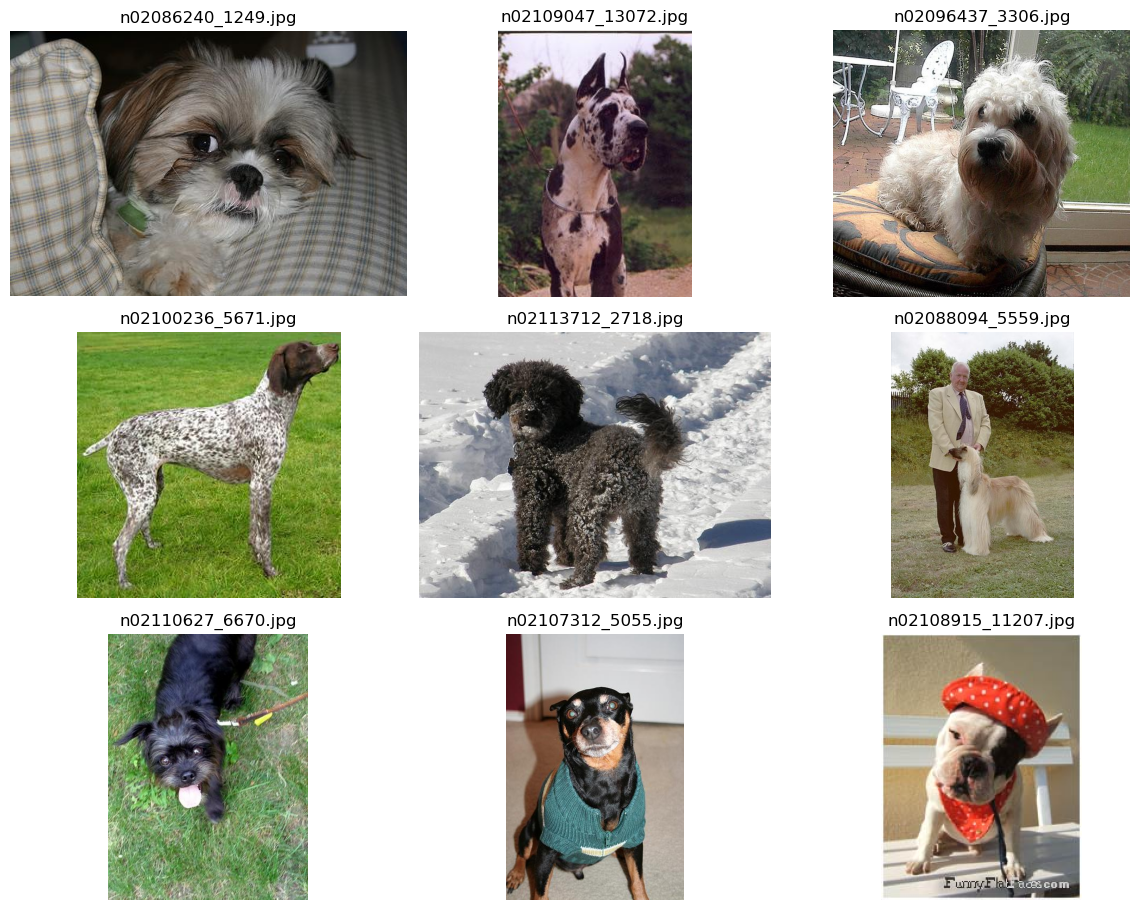

In [5]:
PATH = '/kaggle/working/all-dogs/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    # https://matplotlib.org/users/image_tutorial.html
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Initial observations from looking through a sample of the data is that the images are of various breeds but some images contain multiple dogs and many others also contain human beings. It's also worth noting that the space occupied by dogs in each picture varies greatly. In some pictures they are the main focus while in others they occupy less than a quarter of the space. 

The follwoing code will use information from the annotations create a bounding box around the dogs within the images and crop them out into 64 x 64 px photos which we will use for our model training.

In [6]:
root_images="/kaggle/working/all-dogs/all-dogs/"
root_annots="/kaggle/working/Annotation/Annotation/"

all_images=os.listdir("/kaggle/working/all-dogs/all-dogs/")
print(f"Total images : {len(all_images)}")

breeds = glob.glob('/kaggle/working/Annotation/Annotation/*')
annotation=[]
for b in breeds:
    annotation+=glob.glob(b+"/*")
print(f"Total annotation : {len(annotation)}")

breed_map={}
for annot in annotation:
    breed=annot.split("/")[-2]
    index=breed.split("-")[0]
    breed_map.setdefault(index,breed)
    
print(f"Total Breeds : {len(breed_map)}")

Total images : 20579
Total annotation : 20580
Total Breeds : 120


In [7]:
def bounding_box(image):
    bpath=root_annots+str(breed_map[image.split("_")[0]])+"/"+str(image.split(".")[0])
    tree = ET.parse(bpath)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
    return (xmin,ymin,xmax,ymax)

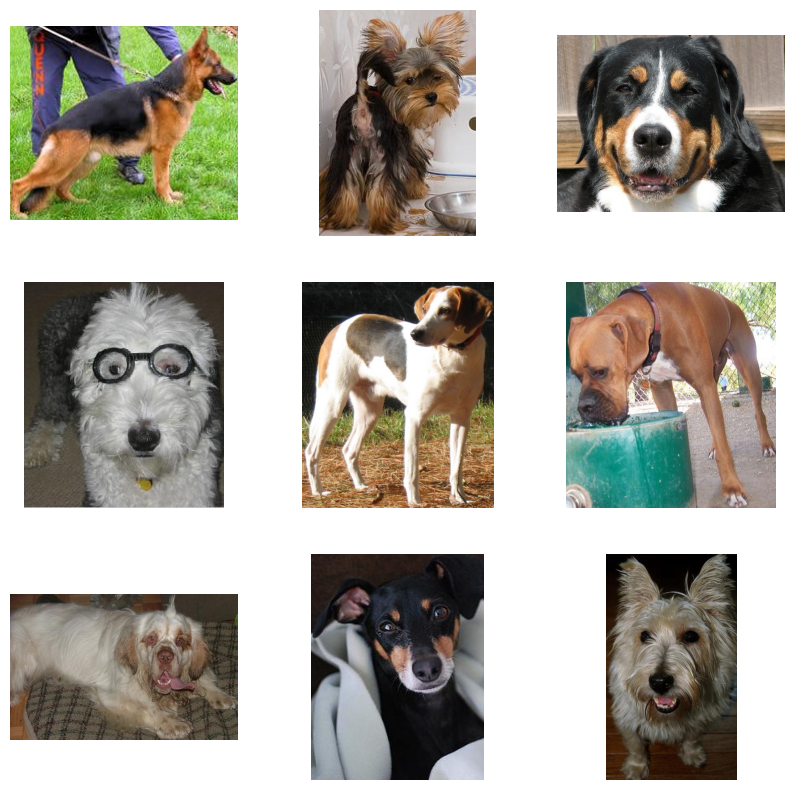

In [8]:
plt.figure(figsize=(10,10))
for i in range(9):
    rnd_indx = np.random.randint(0, len(all_images))
    bbox=bounding_box(all_images[rnd_indx])
    im=Image.open(os.path.join(root_images,all_images[rnd_indx]))
    im=im.crop(bbox)   
    plt.subplot(3,3,i+1)
    plt.axis("off")
    plt.imshow(im)    

Now, let's save our cropped images to be used for modle training.

In [9]:

for i,image in enumerate(all_images):
    bbox=bounding_box(image)
    im=Image.open(os.path.join(root_images,image))
    im=im.crop(bbox)
    try:
        im.save(os.path.join(root_images,image))
    except:
        pass


### Load the Data: 
Using the keras package to load bacthes of 32 images at a time. These are re-sized to 64 x 64 in the process. A further normalisation pre-processing step is also carried out on the image data.

In [10]:
dataset = keras.utils.image_dataset_from_directory(
    '/kaggle/working/all-dogs', label_mode=None, image_size=(64, 64), batch_size=32#,
#     validation_split = 0.875, subset = "training", seed = 7
)
dataset = dataset.map(lambda x: x / 255.0)

Found 20579 files belonging to 1 classes.


#### Discriminator:
We create the discriminator consisting of 3 convolutional layers and 1 fully-connected dense layer. Both the discriminator and the generator models used are based on the [DCGAN](https://keras.io/examples/generative/dcgan_overriding_train_step/) example code provided on the Keras website.

In [11]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"), # addition
        layers.LeakyReLU(alpha=0.2), # addition
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)       

#### Generator:
This is basically a mirror image of the discriminator above.

In [12]:
latent_dim = 256 # changed from 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 256),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             4210688   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 1024)     4195328   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 1024)     4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 1024)      0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 512)      83

GAN Model: Combined generator and discriminator.

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [14]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [15]:
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00003),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

The below is used to create a checkpoint manager to save and reload our model parameters while training over long periods.

In [39]:
checkpoint_dir = '/kaggle/input/ckpt139'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")
checkpoint = tf.train.Checkpoint(#generator_opt=gan.g_optimizer,
#                                   discriminator_opt=gan.d_optimizer,
#                                   gan_opt=gan.g_optimizer,
#                                   generator=generator,
#                                   discriminator=discriminator,
                                  GAN = gan
                                  )

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)#.assert_consumed()
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [17]:
ckpt_manager = tf.train.CheckpointManager(checkpoint, '/kaggle/working/ckpt', max_to_keep=3)

The below is a callback that periodically saves a checkpoint of the model state throughout the training process. Useful when resuming modle training from an earlier session.

In [18]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save() # to delete
#         random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
#         generated_images = self.model.generator(random_latent_vectors)
#         generated_images *= 255
#         generated_images.numpy()
#         for i in range(self.num_img):
#             img = keras.utils.array_to_img(generated_images[i])
#             img.save("generated_img_%03d_%d.png" % (epoch, i))

### Model Training
Now we train the model on the data specififying the number of epochs and setting our callback function.

In [32]:
epochs = 5  # In practice, use ~100 epochs

gan_history  = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim)]
)

Epoch 1/5
644/644 [==============================] - 135s 209ms/step - d_loss: 0.6906 - g_loss: 0.7678
Epoch 2/5
644/644 [==============================] - 135s 210ms/step - d_loss: 0.6974 - g_loss: 0.7591
Epoch 3/5
644/644 [==============================] - 135s 209ms/step - d_loss: 0.6897 - g_loss: 0.7754
Epoch 4/5
644/644 [==============================] - 135s 210ms/step - d_loss: 0.6817 - g_loss: 0.8160
Epoch 5/5
644/644 [==============================] - 135s 210ms/step - d_loss: 0.6942 - g_loss: 0.8172


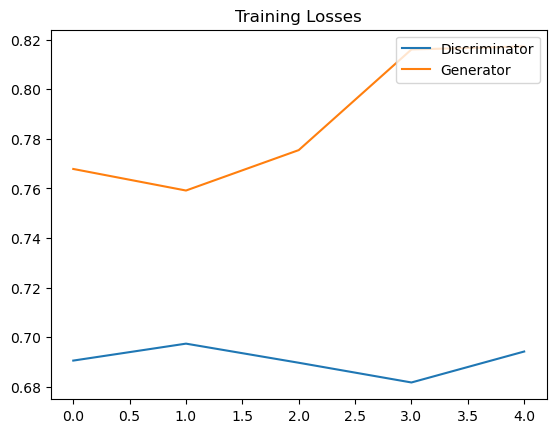

In [33]:
plt.plot(gan_history.history['d_loss'], label='Discriminator')
plt.plot(gan_history.history['g_loss'], label='Generator')
plt.legend(loc='upper right')
plt.title("Training Losses")
plt.show()

## Results and Observations


Let's begin by visualising the discriminator and generator losses over the final 20 epochs.

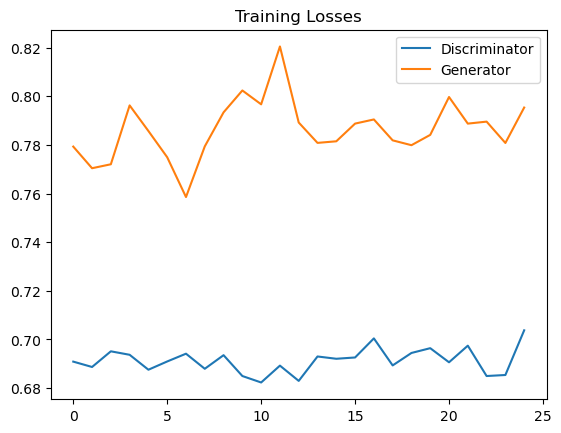

In [30]:
plt.plot(gan_history.history['d_loss'], label='Discriminator')
plt.plot(gan_history.history['g_loss'], label='Generator')
plt.legend(loc='upper right')
plt.title("Training Losses")
plt.show()

Also, let's generate a single image to get a subjective feel for the performance of our model.

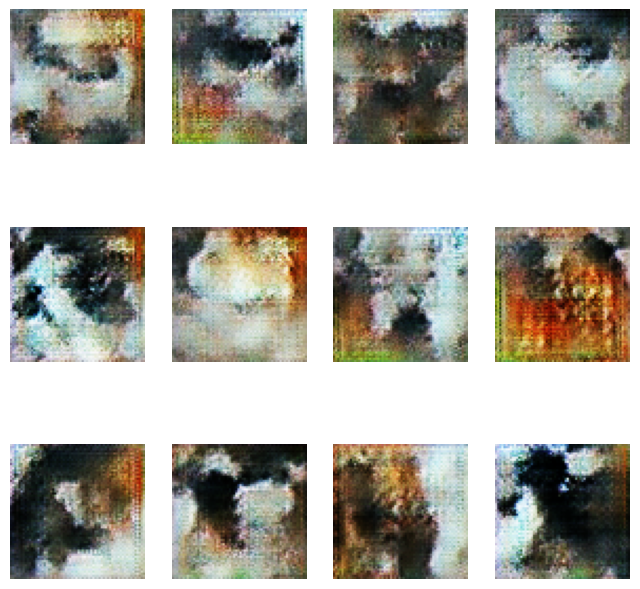

In [40]:
plt.figure(figsize=(8,8))
for i in range(12):

    random_latent_vectors = tf.random.normal(shape=(3, latent_dim))   
    x = gan.generator(random_latent_vectors)  
    plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0]) 

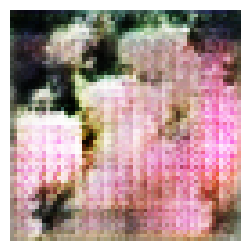

In [51]:
random_latent_vectors = tf.random.normal(shape=(3, latent_dim))   
x = gan.generator(random_latent_vectors)
plt.figure(figsize=(3,3))
plt.axis("off")
plt.imshow((x.numpy() * 255).astype("int32")[0])

The images produced are of varying quality. Most are not very good but sometimes the features of a dog are discernable. On submission, we will be calculating a modified average frechet distance as a more objective measure of the model performance.

## Conclusion

 A visual observation of the samples produced also shows in some of the generated images the features and outlines of a dog can be discerned, with a little effort. Our next step will be to add some complexity to the model, through additional convolutional layers and observe if there is an improvement in performance.  In addition to this we can try using other sophisticated models such as a Cycle GAN, Super Resolution GAN or even a Variational-Auto-Encoder GAN. It is noticed that the performance on the dog dataset is noticeably poorer than an identical architecture's performance on the generating human faces. At this moment our suspicion is that the greater variability between different dog species is the reason for the model's difficulty in learning and reproducing passable dog images. We will be carrying out further study on these architectures and how their performance may be impacted by tweaks to the model hyper-parameters.

## Submission

In [21]:
os.mkdir('/kaggle/working/output_images')

In [27]:
num_img = 200
for i in range(50):
    random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = gan.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for j in range(num_img):
        img = keras.utils.array_to_img(generated_images[i])
        img.save("/kaggle/working/output_images/generated_img_%03d_%d.png" % (i, j))

In [32]:
len(os.listdir('/kaggle/working/output_images'))

shutil.make_archive('images', 'zip', '/kaggle/working/output_images')

10000